In [16]:
import numpy as np
import tensorflow as tf
import math, os, sys, datetime
from pandas_datareader import data as pdr
from datetime import date, timedelta
import yfinance as yf
yf.pdr_override()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn import preprocessing
from models.psooptimizer import Optimizer as PSOOptimizer
from utils.preprocessstock import preprocess
import tensorflow_probability as tfp
from ta import add_all_ta_features
from ta.utils import dropna
from ta.others import CumulativeReturnIndicator
from ta.volatility import KeltnerChannel, DonchianChannel, BollingerBands
from ta.trend import EMAIndicator, IchimokuIndicator
from ta.momentum import KAMAIndicator

#Tickers list
# We can add and delete any ticker from the list to get desired ticker live data
# tickers=['AAPL']
tickers=['AAPL','AMZN','FB','GOOG','MMM','MSFT','NFLX','NKE','NVDA','INTC','CSCO','WMT','TSLA','EBAY',
         'ORCL','CBG.BK','OSP.BK','BBL.BK','SCB.BK','LH.BK','MINT.BK','PTT.BK','BANPU.BK','ADVANC.BK',
         'TRUE.BK','AOT.BK','BEM.BK','BTS.BK','CPALL.BK','CPN.BK']
# 'AAPL','AMZN','FB','GOOG','MMM','MSFT','NFLX','NKE','NVDA','INTC','CSCO','WMT','TSLA','EBAY',
#         'ORCL','CBG.BK','OSP.BK','BBL.BK','SCB.BK','LH.BK','MINT.BK','PTT.BK','BANPU.BK','ADVANC.BK',
#          'TRUE.BK','AOT.BK','BEM.BK','BTS.BK','CPALL.BK','CPN.BK'
# startdate = date.today() - timedelta(days=725)
# enddate= date.today()
startdate = datetime.datetime(2019, 1, 1)
enddate = datetime.datetime(2021, 2, 6)
enddate2 = datetime.datetime(2021, 3, 6)

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [18]:
all_data1 = pd.DataFrame() 
for stocks in tickers:
    ticker = yf.Ticker(stocks)
    data = ticker.history(start=startdate, end=enddate)
    # data.insert(0, 'ticker', stocks)
#     pct_change = abs(((next_price/curr_price)-1)*100)
    
    data['next_close'] = abs(((data['Close'].shift(-1)/data['Close'])-1)*100)
    data = data.drop(columns=['Volume', 'Open', 'High', 'Low', 'Dividends', 'Stock Splits'])
    data = dropna(data)
    if len(data)>504:
        data.drop(data.tail(1).index,inplace=True)
    all_data1 = all_data1.append(data)

In [20]:
all_data1.describe()

,Close,next_close
count,14362.000000,14362.000000
mean,229.529633,1.680801
std,491.763684,1.898440
min,2.389167,0.001746
25%,41.173667,0.581383
50%,70.916962,1.104975
75%,166.357502,2.068967
max,3531.449951,26.229516


In [4]:
all_data2 = pd.DataFrame() 
for stocks in tickers2:
    ticker = yf.Ticker(stocks)
    data = ticker.history(start=startdate, end=enddate2)
    # data.insert(0, 'ticker', stocks)
    volatility_bbm = BollingerBands(close=data["Close"], window=20, window_dev=2)
    data['volatility_bbm'] = volatility_bbm.bollinger_mavg()
    volatility_kcl = KeltnerChannel(high=data["High"], low=data["Low"], close=data["Close"])
    data['volatility_kcl'] = volatility_kcl.keltner_channel_lband()
    trend_ema_fast = EMAIndicator(close=data["Close"], window=14)
    data['trend_ema_fast'] = trend_ema_fast.ema_indicator()
    trend_ichimoku_conv = IchimokuIndicator(high=data["High"], low=data["Low"], window1=9, window2=26, window3=52)
    data['trend_ichimoku_conv'] = trend_ichimoku_conv.ichimoku_conversion_line()
    momentum_kama = KAMAIndicator(close=data["Close"], window=10, pow1=2, pow2=30)
    data['momentum_kama'] = momentum_kama.kama()
    data['next_Close'] = data['Close'].shift(-7)
    data = data.drop(columns=['Volume', 'Open', 'High', 'Low', 'Dividends', 'Stock Splits'])
    data = dropna(data)
    if len(data)>504:
        data.drop(data.tail(1).index,inplace=True)
    all_data2 = all_data2.append(data)

In [5]:
data = all_data1.append(all_data2)
data

,Close,volatility_bbm,volatility_kcl,trend_ema_fast,trend_ichimoku_conv,momentum_kama,next_Close
Date,,,,,,,
2019-01-29,37.651077,37.285227,36.403180,37.619028,37.708279,37.127523,41.608967
2019-01-30,40.223942,37.376628,36.439408,37.966350,38.684357,37.460947,41.657860
2019-01-31,40.513611,37.480322,36.559248,38.305985,39.031225,37.772888,41.418289
2019-02-01,40.533089,37.776434,36.857551,38.602932,39.031225,38.035725,41.775200
2019-02-04,41.684422,38.056237,37.144331,39.013797,39.354962,38.491617,41.601627
...,...,...,...,...,...,...,...
2021-02-17,50.359642,50.273238,48.767386,50.570931,51.100224,50.603822,52.334526
2021-02-18,51.100224,50.409012,48.919617,50.641504,51.593945,50.628972,54.556278
2021-02-19,50.853363,50.495413,49.055391,50.669752,51.840807,50.640341,55.049999


In [6]:
timesteps = 7
min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(data.iloc[:, [1,2,3,4,5]])
features = features[:len(features)//timesteps*timesteps].reshape((len(features)//timesteps, timesteps, 5))

In [7]:
labels = data.iloc[:, [6]].to_numpy()
labels = labels[:len(labels)//timesteps*timesteps].reshape((len(labels)//timesteps, timesteps, 1))

In [8]:
train_test_split_factor = .80
validation_split_factor = .20
train_x, train_y, test_x, test_y = features[:math.floor(len(features)*train_test_split_factor)], labels[:math.floor(len(labels)*train_test_split_factor)], features[math.floor(len(features)*train_test_split_factor):], labels[math.floor(len(labels)*train_test_split_factor):]
train_x, test_x = np.expand_dims(train_x, axis=1), np.expand_dims(test_x, axis=1)
train_x, test_x = np.expand_dims(train_x, axis=-1), np.expand_dims(test_x, axis=-1)
input_shape = train_x.shape
# train_y, test_y = np.expand_dims(train_y, axis=2), np.expand_dims(test_y, axis=2) # for use with TimeDistributed
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(1152, 1, 7, 5, 1) (1152, 7, 1) (288, 1, 7, 5, 1) (288, 7, 1)


In [24]:
train_y.min()

13.165271759033203

In [9]:
features[0:1]

array([[[0.02664539, 0.02836251, 0.0256493 , 0.02705791, 0.02758611],
        [0.02676064, 0.02841   , 0.02607457, 0.02821317, 0.02799152],
        [0.02689139, 0.02856711, 0.02649042, 0.02862371, 0.0283708 ],
        [0.02726477, 0.02895818, 0.026854  , 0.02862371, 0.02869038],
        [0.02761759, 0.02933414, 0.02735707, 0.02900687, 0.02924469],
        [0.02802043, 0.02975722, 0.0279095 , 0.02950529, 0.03038968],
        [0.02838092, 0.03014712, 0.02839065, 0.02985244, 0.03125085]]])

In [10]:
labels[0:1]

array([[[41.60896683],
        [41.6578598 ],
        [41.41828918],
        [41.77519989],
        [41.60162735],
        [41.75320053],
        [41.66029739]]])

In [11]:
def build_model(loss):
    layers = [
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', input_shape=input_shape[1:])),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', dilation_rate=2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(14, 3, padding='same', activation='relu', dilation_rate=1)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(36, 3, padding='same', activation='relu', dilation_rate=1)),
        tf.keras.layers.Dense(70, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(7, activation='linear')
    ]
    model = tf.keras.models.Sequential(layers=layers)
    model.compile(optimizer='adam', loss=loss)
    return model

In [12]:
N = 10
STEPS = 150
LOSS = 'mse'
BATCH_SIZE = 32

In [13]:
def run_backpropagation(x_train, y_train, epochs=0):
    best_model = None
    best_score = float('inf')
    if epochs == 0:
        epochs = STEPS
    for i in range(N):
        model_s = build_model(LOSS)
        model_s.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=BATCH_SIZE,
            verbose=0
        )
        train_score = model_s.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
        if train_score < best_score:
            best_model = model_s
            best_score = train_score
        return best_model

In [14]:
model_s = run_backpropagation(train_x, train_y)
b_train_score = model_s.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
b_test_score = model_s.evaluate(test_x[:64], test_y[:64], batch_size=BATCH_SIZE, verbose=0)
print("Backprop -- train: {:.4f}  test: {:.4f}".format(b_train_score, b_test_score))

model_p = run_backpropagation(train_x, train_y) # initilize weights
pso = PSOOptimizer(model=model_p,
                  loss=LOSS,
                  n=N,
                  acceleration=1.0,
                  local_rate=.6,
                  global_rate=.4)
pso.fit(train_x, train_y, steps=STEPS, batch_size=BATCH_SIZE)
model_p = pso.get_best_model()
p_train_score = model_p.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
p_test_score = model_p.evaluate(test_x[:64], test_y[:64], batch_size=BATCH_SIZE, verbose=0)
print("PSO -- train: {:.4f}  test: {:.4f}".format(p_train_score, p_test_score))

Backprop -- train: 117.3880  test: 150.2037
PSO -- Initial best score 109.3449
 [====================] 
PSO -- train: 4386.0498  test: 11282.6904


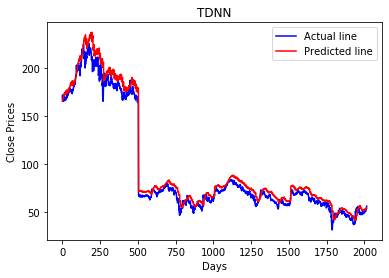

In [15]:
pred = model_s.predict(test_x)
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.title('TDNN')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error  as MSE
print('MSE: {:0.4f}' .format(MSE(test_y_reshape, close_pred)))
print('EVS = {:0.4f}'.format(explained_variance_score(test_y_reshape, close_pred)))

MSE: 60.1823
EVS = 0.9903


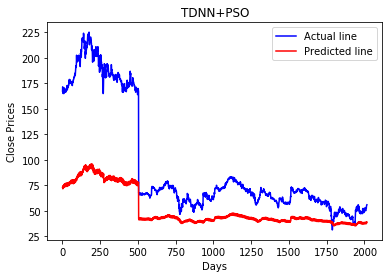

In [17]:
pred = model_p.predict(test_x)
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.title('TDNN+PSO')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error  as MSE
print('MSE: {:0.4f}' .format(MSE(test_y_reshape, close_pred)))
print('EVS = {:0.4f}'.format(explained_variance_score(test_y_reshape, close_pred)))

MSE: 3150.2755
EVS = 0.5497


In [19]:
model_s.save('weights/tdnn.h5')
model_s.save_weights('weights/tdnn_weight_only.h5')
model_p.save('weights/tdnnpso.h5')
model_p.save_weights('weights/tdnnpso_weight_only.h5')